# Plot spectral peaks found for a geophone station and the array detection counts for a day in a specific frequency range

In [1]:
# Imports
from os.path import join
from pandas import read_csv, to_datetime

from utils_basic import SPECTROGRAM_DIR as indir, GEO_STATIONS as stations, STARTTIME_GEO as starttime, ENDTIME_GEO as endtime
from utils_basic import get_day_begin_and_end
from utils_spec import assemble_spec_filename, string_to_time_label, read_geo_spectrograms, read_spectral_peaks, read_spectral_peak_bin_counts
from utils_plot import plot_geo_total_psd_peaks_and_array_counts, save_figure

In [2]:
# Inputs
# Data
station_to_plot = "A01"
day = "2020-01-13"
min_freq = 0.0
max_freq = 200.0
window_length = 60.0
overlap = 0.0
downsample = True
downsample_factor = 60

starttime, endtime = get_day_begin_and_end(day)

# Finding peaks
rbw_threshold = 0.2
prom_threshold = 5
freqmin = None
freqmax = None


# Grouping
time_bin_width = "1min"
freq_bin_width = 1.0 # in Hz
min_freq = 0.0
max_freq = 500.0

# Plotting
marker_size = 2

major_time_spacing = 24
minor_time_spacing = 6

dbmin = -30
dbmax = 0

rbwmin = rbw_threshold
rbwmax = 0.5

min_count = 0
max_count = len(stations)


In [3]:
# Read the spectrograms of the example station
filename = assemble_spec_filename("whole_deployment", "daily", "geo", station_to_plot, window_length, overlap, downsample, downsample_factor = downsample_factor)
inpath = join(indir, filename)
time_label = string_to_time_label(day)

stream = read_geo_spectrograms(inpath, time_labels = time_label)

In [4]:
# Compute the total PSD and stich the spectrograms together
stream.stitch()
trace_total = stream.get_total_power()

In [6]:
# Read all spectral peaks and find the peaks for the example station
if downsample:
    filename = f"geo_spectral_peaks_window{window_length:.0f}s_overlap{overlap:.1f}_downsample{downsample_factor:d}_prom{prom_threshold:.0f}db_rbw{rbw_threshold}.csv"
else:
    filename = f"geo_spectral_peaks_window{window_length:.0f}s_overlap{overlap:.1f}_prom{prom_threshold:.0f}db_rbw{rbw_threshold}.csv"
    
inpath = join(indir, filename)

peak_df = read_spectral_peaks(inpath)
peak_df_to_plot = peak_df.loc[peak_df["station"] == station_to_plot]

peak_df_to_plot = peak_df_to_plot.loc[(peak_df["time"] > starttime) & (peak_df["time"] < endtime)]

In [13]:
# Read the spectral-peak bin counts
if downsample:
    filename = f"geo_spectral_peak_bin_counts_window{window_length:.0f}s_overlap{overlap:.1f}_downsample{downsample_factor}_prom{prom_threshold:.0f}db_rbw{rbw_threshold:.1f}.h5"
else:
    filename = f"geo_spectral_peak_bin_counts_window{window_length:.0f}s_overlap{overlap:.1f}_prom{prom_threshold:.0f}db_rbw{rbw_threshold:.1f}.h5"

inpath = join(indir, filename)

time_bin_centers, freq_bin_centers, detect_counts = read_spectral_peak_bin_counts(inpath)

time_bin_centers_to_plot = time_bin_centers[ (time_bin_centers > starttime) & (time_bin_centers < endtime) ]
detect_counts_to_plot = detect_counts[ :, (time_bin_centers > starttime) & (time_bin_centers < endtime) ]

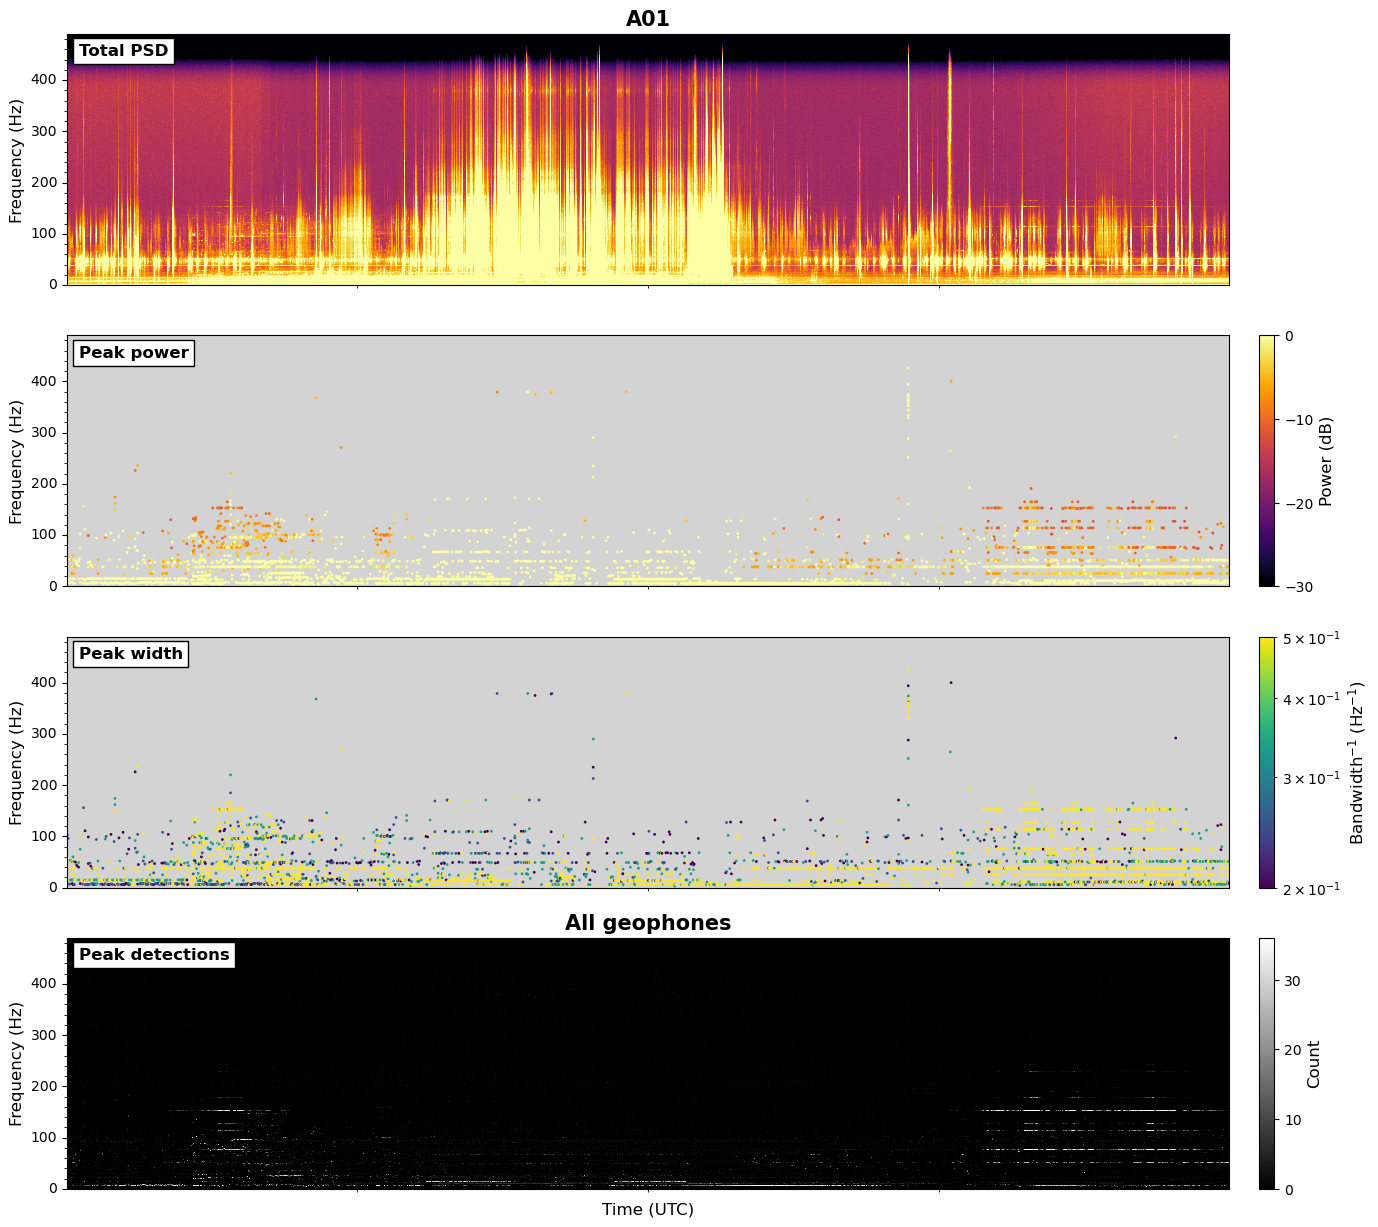

In [14]:
# Plot the results
fig, axes, power_cbar, rbw_cbar, coutn_cbar = plot_geo_total_psd_peaks_and_array_counts(trace_total, peak_df_to_plot, time_bin_centers_to_plot, freq_bin_centers, detect_counts_to_plot, 
                                                                                        marker_size = marker_size, 
                                                                                        dbmin = dbmin, dbmax = dbmax, rbwmin = rbwmin, rbwmax = rbwmax, min_count = min_count, max_count = max_count,
                                                                                        major_time_spacing = major_time_spacing, minor_time_spacing = minor_time_spacing)

In [ ]:
figname = f"geo_total_psd_peaks_and_array_counts_day{day}_{station_to_plot}.png"
save_figure(fig, figname)